# Chapitre 5 : Fiabilité du système distribué

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import * # Import principal : module de simulation

%matplotlib inline 

In [2]:
NB_NODES = 50
DURATION = 3601   # Nb samples
REVOLUTION = 1800  # Nb samples
SAMPLE_FREQ = 0.1  # Hz, 1 sample every 10 seconds
CONNECTION_RANGE = 30 # m

# Variables globales pour l'analyse
SAMPLE_STEP = 30
NB_REPETITIONS = 1

# Variables globales figures
TMAX = REVOLUTION/SAMPLE_FREQ
IDX = np.arange(0, TMAX, (1/SAMPLE_FREQ)*SAMPLE_STEP) # conversion en secondes

## 1. Analyse de la fiabilité du graphe de référence
Résultats obtenus avec le script `chap5_reliability_undivided.py`

In [3]:
df_ref = {}
df_ref[1] = pd.read_csv('output\data\sat50_reliability_undivided_year1.csv' , sep=',', index_col='Unnamed: 0')
df_ref[12] = pd.read_csv('output\data\sat50_reliability_undivided_year12.csv' , sep=',', index_col='Unnamed: 0')

#df_ref = df_ref.set_index('Timestamp')
#df_ref

In [6]:
# timestamp: 60

PATH = '..\..\data\\v10-swarm-50s-pert\\coords_LLO-'
PROPAGATION = 'J4'
ROW_DATA_START = 7

swarm_months = {}
MONTHS_TEST = [12]
for m in MONTHS_TEST:
    print('\nExtracting month', m)
    satellites = {} # Dict(sat_id: DataFrame)
    with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
        for i in range(NB_NODES):
                df = pd.read_csv(PATH+str(i)+'-'+PROPAGATION+'_'+str(m)+'.csv', skiprows= lambda x: x<ROW_DATA_START, header=0)
                satellites[i] = df
                pbar.update(1)
            
    swarm_data = {} # Dict{timestamp: Swarm}
    with tqdm(total = REVOLUTION, desc = 'Converting to Swarm') as pbar:
        for t in range(REVOLUTION):
            swarm_data[t] = Swarm(
                connection_range = CONNECTION_RANGE, 
                nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                )
            pbar.update(1)
            
    # Ré-échantillonner les topologies (réduit les calculs)
    swarm_topo = {}
    for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
        swarm_topo[t] = swarm_data[t]
        
    neighbor_matrices = {} # Dict{timestamp: matrix}
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Computing neighbor matrices') as pbar:
        for t in swarm_topo.keys():
            neighbor_matrices[t] = swarm_topo[t].neighbor_matrix(weighted=True)
            pbar.update(1)
            
    # Création des graphes associés  
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Generating graphs') as pbar:
        for t in swarm_topo.keys():
            swarm_topo[t].create_graph()
            pbar.update(1)
            
    # Enlever les ISL trop chers de l'essaim (ceux dont le coût est supérieur au coût du plus court chemin)
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc = 'Removing expensive edges') as pbar:
        for t in swarm_topo.keys():
            swarm_topo[t].remove_expensive_edges()
            pbar.update(1)
            
    swarm_months[m] = swarm_topo


Extracting month 12


Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '..\\..\\data\\v10-swarm-50s-pert\\coords_LLO-0-J4_12.csv'

Visualisation de l'évolution temporelle des métriques sur le graphe de référence :
 * robustesse : robustesse de flux, coût de routage, efficience réseau
 * résilience : redondance des chemins, disparité, nombre de noeuds critiques

(0.0, 30.0)

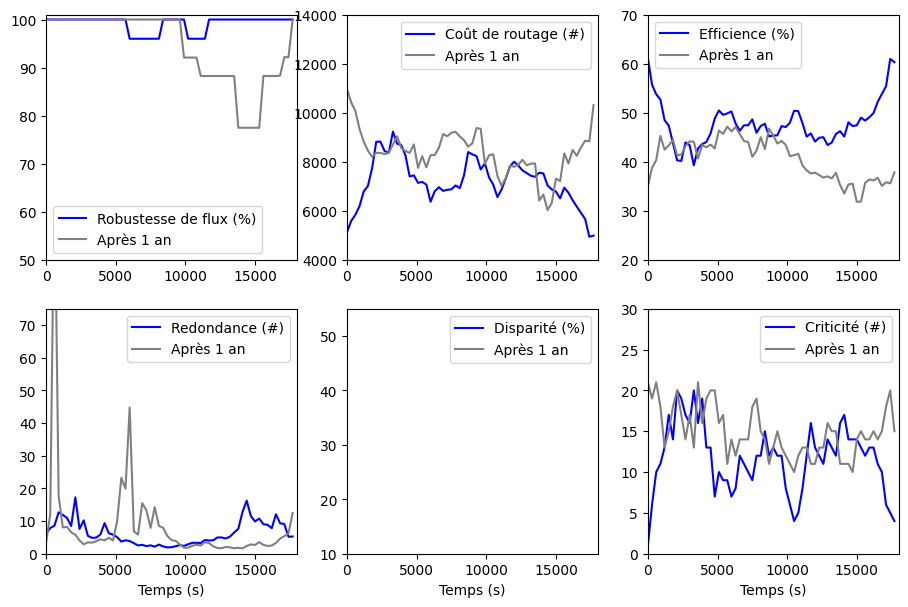

In [13]:
fig, axes = plt.subplots(figsize=(11,7), nrows=2, ncols=3)

ax = axes[0][0]
ax.plot(IDX, df_ref[1]['RFlow']*100, c='blue', label='Robustesse de flux (%)')
ax.plot(IDX, df_ref[12]['RFlow']*100, c='gray', label='Après 1 an')
ax.legend()
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 5000))
ax.set_ylim(50, 101)

ax = axes[0][1]
ax.plot(IDX, df_ref[1]['RCost'], c='blue', label='Coût de routage (#)')
ax.plot(IDX, df_ref[12]['RCost'], c='gray', label='Après 1 an')
ax.legend()
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 5000))
ax.set_ylim(4000, 14000)

ax = axes[0][2]
ax.plot(IDX, df_ref[1]['Efficiency']*100, c='blue', label='Efficience (%)')
ax.plot(IDX, df_ref[12]['Efficiency']*100, c='gray', label='Après 1 an')
ax.legend()
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 5000))
ax.set_ylim(20, 70)


ax = axes[1][0]
ax.plot(IDX, df_ref[1]['Redundancy'], c='blue', label='Redondance (#)')
ax.plot(IDX, df_ref[12]['Redundancy'], c='gray', label='Après 1 an')
ax.legend()
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 5000))
ax.set_xlabel('Temps (s)')
ax.set_ylim(0, 75)

ax = axes[1][1]
ax.plot(IDX, df_ref[1]['Disparity']*100, c='blue', label='Disparité (%)')
ax.plot(IDX, df_ref[12]['Disparity']*100, c='gray', label='Après 1 an')
ax.legend()
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 5000))
ax.set_xlabel('Temps (s)')
ax.set_ylim(10, 55)

ax = axes[1][2]
ax.plot(IDX, df_ref[1]['Criticity'], c='blue', label='Criticité (#)')
ax.plot(IDX, df_ref[12]['Criticity'], c='gray', label='Après 1 an')
ax.legend()
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 5000))
ax.set_xlabel('Temps (s)')
ax.set_ylim(0, 30)

In [15]:
# Nombre moyen de noeuds critiques (epsilon=0.05)
df_ref[12]['Criticity'].mean()

14.9

## 2. Comparaison des performances des graphes divisés 
Résultats pour RND, MIRW et FFD obtenus avec le script `chap5_reliability_divided.py`

Résultats pour k-means obtenus avec le script `chap5_reliability_kmeans.py`

In [40]:
MONTH = 12

df_rnd = pd.read_csv('output\data\sat50_reliability_RND_year'+str(MONTH)+'.csv', sep=',', index_col='Unnamed: 0')
df_mirw = pd.read_csv('output\data\sat50_reliability_MIRW_year'+str(MONTH)+'.csv', sep=',', index_col='Unnamed: 0')
df_ffd = pd.read_csv('output\data\sat50_reliability_FFD_year'+str(MONTH)+'.csv', sep=',', index_col='Unnamed: 0')
df_kmeans = pd.read_csv('output\data\sat50_reliability_KMeans_year'+str(MONTH)+'.csv', sep=',', index_col='Unnamed: 0')

df_rnd.head()

,Timestamp,RFlow,RCost,Efficiency,Redundancy,Disparity,Criticity
0,0,1.0,900,0.375477,3.685714,0.0,19
1,30,1.0,848,0.408266,10.980952,0.0,17
2,60,1.0,834,0.410526,113.847619,0.0,19
3,90,1.0,778,0.459773,17.466667,0.0,16
4,120,1.0,726,0.415219,6.819048,0.0,13


In [41]:
ref_rcost_avg = df_ref[MONTH]['RCost'].mean()
print('Coût de routage moyen dans le graphe original:', int(ref_rcost_avg), 'transmissions')

Coût de routage moyen dans le graphe original: 8366 transmissions


Text(0.5, 0, 'Temps (s)')

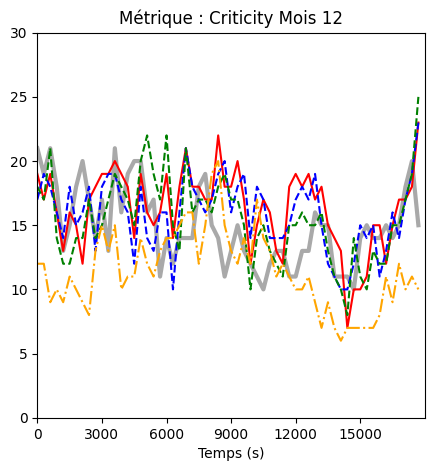

In [51]:
plt.figure(figsize=(5,5))
metric = 'Criticity'    # RFlow, RCost, Efficiency, Redundancy, Disparity, Criticity

plt.plot(IDX, df_ref[MONTH][metric], c='darkgray', lw=3, label='Référence')
plt.plot(IDX, df_rnd[metric], '-r', label='RND')
plt.plot(IDX, df_mirw[metric], '--b', label='MIRW')
plt.plot(IDX, df_ffd[metric], '--g', label='FFD')
plt.plot(IDX, df_kmeans[metric], ls='-.', c='orange', label='KMeans')
#plt.legend()
plt.title('Métrique : '+metric+ ' Mois '+str(MONTH))
plt.xlim(0,TMAX)
plt.xticks(np.arange(0, TMAX, 3000))
plt.ylim(0, 30)
plt.xlabel('Temps (s)')

(-20.0, 20.0)

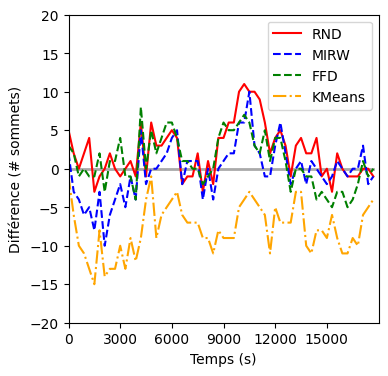

In [19]:
# Visualisation de l'écart des métriques par rapport aux métriques de référence
fig,ax = plt.subplots(figsize=(4,4))
metric = 'Criticity'    # paramètre à changer si besoin

ax.plot(IDX, df_ref[MONTH][metric] - df_ref[MONTH][metric], c='darkgray', lw=2) 
ax.plot(IDX, df_rnd[metric] - df_ref[MONTH][metric], '-r', label='RND')
ax.plot(IDX, df_mirw[metric] - df_ref[MONTH][metric], '--b', label='MIRW')
ax.plot(IDX, df_ffd[metric] - df_ref[MONTH][metric], '--g', label='FFD')
ax.plot(IDX, df_kmeans[metric] - df_ref[MONTH][metric], ls='-.', c='orange', label='KMeans')


ax.legend()
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Différence (# sommets)')
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 3000))
ax.set_ylim(-20, 20)

## 2. Analyse des distributions

In [48]:
import matplotlib.ticker as ticker

def box_plot(datasets, index, fill_color, hatch_pattern=None):
    x_pos_range = np.arange(len(datasets)) / (len(datasets) - 1)
    x_pos = (x_pos_range * 0.5) + 0.75
    bp = ax.boxplot(
        np.array(datasets[index]), sym='', whis=[0, 100], widths=0.6 / len(datasets),
        labels=list(datasets[0]),
        positions=[x_pos[index] + j * 1 for j in range(len(datasets[index].T))],
        patch_artist=True
    )
    for median in bp['medians']:
        median.set_color('black')
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)
        if hatch_pattern: 
            patch.set(hatch=hatch_pattern)    
    return bp

In [37]:
# Timestamps représentant des topologies à densité faible, intermédiaire, ou forte
T_HIGH, T_LOW, T_MED = 348, 900, 1344

range_low = np.arange(T_LOW-5*SAMPLE_STEP, T_LOW+5*SAMPLE_STEP, SAMPLE_STEP).tolist()
range_avg = np.arange(T_MED-5*SAMPLE_STEP, T_MED+5*SAMPLE_STEP, SAMPLE_STEP).tolist() 
range_high = np.arange(T_HIGH-5*SAMPLE_STEP, T_HIGH+5*SAMPLE_STEP, SAMPLE_STEP).tolist()

In [102]:
metric = 'Disparity' # à changer si besoin

data_original = pd.DataFrame({
    'Faible': df_ref[metric].loc[df_ref.index.isin(range_low)].tolist(),
    'Moyenne': df_ref[metric].loc[df_ref.index.isin(range_avg)].tolist(),
    'Elevée': df_ref[metric].loc[df_ref.index.isin(range_high)].tolist()
})

data_rnd = pd.DataFrame({
    'Faible': df_rnd[metric].loc[df_rnd.index.isin(range_low)].tolist(),
    'Moyenne': df_rnd[metric].loc[df_rnd.index.isin(range_avg)].tolist(),
    'Elevée': df_rnd[metric].loc[df_rnd.index.isin(range_high)].tolist()
})

data_mirw = pd.DataFrame({
    'Faible': df_mirw[metric].loc[df_mirw.index.isin(range_low)].tolist(),
    'Moyenne': df_mirw[metric].loc[df_mirw.index.isin(range_avg)].tolist(),
    'Elevée': df_mirw[metric].loc[df_mirw.index.isin(range_high)].tolist()
})

data_ffd = pd.DataFrame({
    'Faible': df_ffd[metric].loc[df_ffd.index.isin(range_low)].tolist(),
    'Moyenne': df_ffd[metric].loc[df_ffd.index.isin(range_avg)].tolist(),
    'Elevée': df_ffd[metric].loc[df_ffd.index.isin(range_high)].tolist()
})

data_kmeans = pd.DataFrame({
    'Faible': df_kmeans[metric].loc[df_kmeans.index.isin(range_low)].tolist(),
    'Moyenne': df_kmeans[metric].loc[df_kmeans.index.isin(range_avg)].tolist(),
    'Elevée': df_kmeans[metric].loc[df_kmeans.index.isin(range_high)].tolist()
})

datasets = [data_original, data_rnd, data_mirw, data_ffd, data_kmeans]

In [103]:
# A exécuter pour les métriques exprimées en % (RFlow, Efficiency, Disparity)
for i,df in enumerate(datasets):
    datasets[i] = datasets[i]*100

Text(0.5, 0, 'Densité de noeuds')

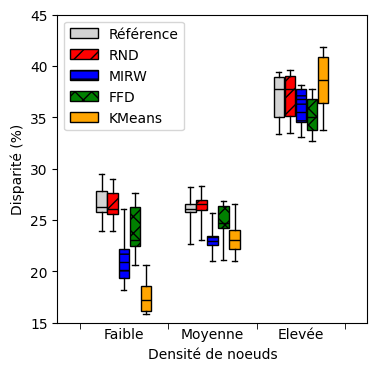

In [105]:
# Distribution des métriques de référence et par algorithme
fig, ax = plt.subplots(figsize=(4,4))
bp0 = box_plot(datasets, 0, 'lightgray')
bp1 = box_plot(datasets, 1, 'red', hatch_pattern='//')
bp2 = box_plot(datasets, 2, 'blue', hatch_pattern='--')
bp3 = box_plot(datasets, 3, 'green', hatch_pattern='xx')
bp4 = box_plot(datasets, 4, 'orange', hatch_pattern=None)

plt.xticks(np.arange(len(list(datasets[0]))) + 1)
plt.gca().xaxis.set_minor_locator(ticker.FixedLocator(
    np.array(range(len(list(datasets[0])) + 1)) + 0.5)
)
plt.gca().tick_params(axis='x', which='minor', length=4)
plt.gca().tick_params(axis='x', which='major', length=0)

ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], 
    ['Référence', 'RND', 'MIRW', 'FFD', 'KMeans'], 
    loc='best')
ax.set_ylim(15,45)
ax.set_ylabel('Disparité (%)')
ax.set_xlabel('Densité de noeuds')

Text(0.5, 0, 'Densité de noeuds')

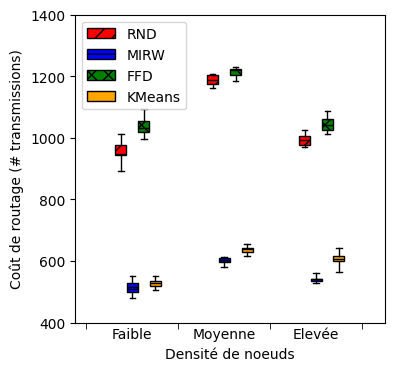

In [55]:
# Cas particulier du RCost en raison de l'échelle
fig, ax = plt.subplots(figsize=(4,4))
bp1 = box_plot(datasets, 1, 'red', hatch_pattern='//')
bp2 = box_plot(datasets, 2, 'blue', hatch_pattern='--')
bp3 = box_plot(datasets, 3, 'green', hatch_pattern='xx')
bp4 = box_plot(datasets, 4, 'orange', hatch_pattern=None)

plt.xticks(np.arange(len(list(datasets[0]))) + 1)
plt.gca().xaxis.set_minor_locator(ticker.FixedLocator(
    np.array(range(len(list(datasets[0])) + 1)) + 0.5)
)
plt.gca().tick_params(axis='x', which='minor', length=4)
plt.gca().tick_params(axis='x', which='major', length=0)

ax.legend(
    [bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0]], 
    ['RND', 'MIRW', 'FFD', 'KMeans'], 
    loc='upper left')
ax.set_ylim(400, 1400)
ax.set_ylabel('Coût de routage (# transmissions)')
ax.set_xlabel('Densité de noeuds')